In [10]:
import sys
sys.path.append("../")
from src.utils.data_util import biocaser2text
from src.eval_method import CrossValidation
from src.experiment import Experiment
from src.metrics import Accuracy,Precision,Recall,F1Score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from src.preprocess import BasicTextPreprocess,BasicTextFeatureExtraction
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from src.preprocess.preprocessor import BasicTextPreprocess

In [3]:
## this should load a dataframe, which col1 being the documents and col2 being the labels.
from utils.data_util import get_raw_promed_df
data_df = get_raw_promed_df()
data_df.head(5)

found files: 3009
found files: 1530


,docs,labels
0,"\n \n \n \n AVIAN INFLUENZA, HUMAN (109) - IND...",1
1,Health officials in Hong Kong say that...,1
2,\n \n EQUINE INFLUENZA - CHINA\n \n **********...,1
3,"\n \n \n \n SALMONELLOSIS SENFTENBERG, BASIL -...",1
4,"\n \n GIARDIASIS, HUMAN - UNITED KINGDOM: (YOR...",1


In [4]:
bp = BasicTextPreprocess()
data_df = bp.bert_process(data_df, "docs")
data_df.head(5)

,docs,labels
0,"avian influenza, human (109) - indonesia, ...",1
1,health officials in hong kong say that avi...,1
2,equine influenza - china ******************...,1
3,"salmonellosis senftenberg, basil - europe ...",1
4,"giardiasis, human - united kingdom: (yorkshi...",1


In [5]:
data_df["doc_len"] = data_df["docs"].apply(lambda x: len(x.split(" ")))

In [6]:
data_df["doc_len"].min(),data_df["doc_len"].max()

(11, 8784)

In [40]:
def hist(data, bins, title="hist", range = None):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes()
    plt.ylabel("Proportion")
    
    # the histogram of the data
    n, bins, patches = plt.hist(data, bins, density=False, facecolor='g',rwidth = 1, alpha=0.75)
    # histtype : {'bar', 'barstacked', 'step', 'stepfilled'}, optional


    plt.xlabel('Length of Docs')
    plt.ylabel('Number of Docs')
    plt.title('Histogram of Length of Doucment')
    plt.show()
    return

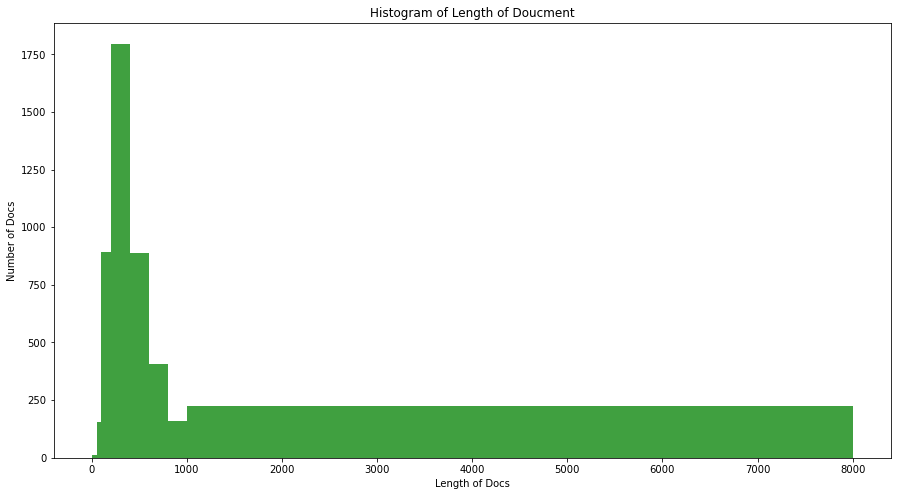

In [41]:
bins = [0,50,100,200,400,600,800,1000,8000]
hist(data_df["doc_len"].to_numpy(),bins)

In [ ]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [ ]:
data_df["docs_split"] = data_df["docs"].apply(get_split)

In [ ]:
data_df.head()

In [ ]:
bp = BasicTextPreprocess()

bfe = BasicTextFeatureExtraction(["tfidf","bow","bigram",["tfidf","bigram"],["bow","bigram"],["tfidf","trigram"],["bow","trigram"],["tfidf","bigram","trigram"]])

cv = CrossValidation(n_splits=10, n_repeats=10, random_state=12345)

acc = Accuracy()
pre = Precision()
rec = Recall()
f1 = F1Score()

svm = LinearSVC(random_state=0, tol=1e-5,max_iter=5000)
svm.name = "svm"
dtree = DecisionTreeClassifier(random_state=0,criterion='entropy')
dtree.name="dtree"
bnb = BernoulliNB()
bnb.name = "BernoulliNB"
gnb = GaussianNB()
gnb.name = "GaussianNB"
mnb = MultinomialNB()
mnb.name = "MultinomialNB"
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.name = "RandomForest"

# chi2 feature selection
ch2 = SelectKBest(chi2, k=9000)
svm_ch2 = Pipeline([('sel', ch2), ('cls', svm)])
svm_ch2.name = "svm+chi2"

# chi2 feature selection
dtree_ch2 = Pipeline([('sel', ch2), ('cls', dtree)])
dtree_ch2.name = "dtree+chi2"

# chi2 feature selection
bnb_ch2 = Pipeline([('sel', ch2), ('cls', bnb)])
bnb_ch2.name = "BernoulliNB+chi2"

# chi2 feature selection
gnb_ch2 = Pipeline([('sel', ch2), ('cls', gnb)])
gnb_ch2.name = "GaussianNB+chi2"

# chi2 feature selection
mnb_ch2 = Pipeline([('sel', ch2), ('cls', mnb)])
mnb_ch2.name = "MultinomialNB+chi2"

# chi2 feature selection
mnb_rf = Pipeline([('sel', ch2), ('cls', rf)])
mnb_rf.name = "RandomForest+chi2"

In [ ]:
exp = Experiment(
    data_df = data_df,
    preprocessor = bp,
    extractor = bfe,
    eval_method=cv,
#     models=[svm,dtree,bnb,gnb,mnb,svm_ch2,dtree_ch2,bnb_ch2,gnb_ch2,mnb_ch2],
    models = [svm],
    metrics=[acc,pre,rec,f1],
    result_file = "../promed_result.csv",
    verbose = True
).run()

In [ ]:
data_df.iloc[0].docs

In [ ]:
data_df["labels"].value_counts()